# Entrenamiento y validación YOLO

Última revisión: 01/02/2026

En este documento se explicarán los siguientes conceptos:

1.  Proceso de recolección de datos
2.  Puesta en marcha del modelo YOLO
3.  Entrenamiento con los datos obtenidos

Es importante cambiar el **tipo entorno de ejecución** para que se centre en la **GPU**. Caso contrario, el entrenamiento podría **demorarse o tener complicaciones**.

Puede cambiar el tipo de entorno de ejecución dentro de Google Colab dirigiéndose a `Entorno de ejecución > Cambiar tipo de entorno de ejecución > GPU T4`.

In [ ]:
!nvidia-smi

> **Nota**: Este comando verifica que estemos en el entorno de ejecución adecuado.

Para facilitar el acceso a datos y scripts, ofrecemos una **carpeta con los archivos necesarios**.

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1uGalK5NnQrRRN0yDiigqWuNfgvpmXk1x"
output = "plate-cli.zip"
gdown.download(url, output, quiet=False)

In [ ]:
!unzip -q /content/plate-cli.zip

## Recolección de datos

Para que el modelo sea capaz de diferenciar entre **matrículas de distintos países**, es fundamental contar con una **gran cantidad de muestras** _(imágenes)_.

Nuestro método para obtener esas imágenes es efectivo y nos ahorra mucho tiempo, ya que el proceso está automatizado. Se basa en una técnica llamada **"web scraping"**.

Mediante una **automatización del navegador web** _(usando [Selenium](https://www.selenium.dev/))_, es posible obtener cientos de imágenes de diferentes países de Latinoamérica que se encuentran en **Facebook Marketplace**. Basta con ubicar una de las ciudades del país, y Selenium se encarga de ir la sección de vehículos en Marketplace para extraer las imágenes.

> **Dato adicional**: Para evitar obtener imágenes repetidas, el algoritmo guarda las direcciones de las imágenes ya descargadas, de forma que si una imagen se encuentra en la lista, no se descarga nuevamente.

Con este algoritmo, es posible descargar al menos unas 200 imágenes por país, dando como resultado la siguiente estructura:

```text
📁 images/
├── 📁 argentina/
    ├── 📷 argentina-0.jpg
    ├── 📷 argentina-1.jpg
    ├── ...
├── 📁 bolivia/
├── 📁 brazil/
└── ...
```

> **Nota**: Ejecutar el script en **Google Colab** es complicado porque se suele detectar al navegador como un bot, provocando redirecciones no deseadas.

### Anotaciones y filtrado de imágenes

Ahora es momento de **clasificar** estas imágenes en distintas **clases** _(una clase para cada país)_, marcando el **bounding box** donde se encuentran las matrículas. Esto le sirve al modelo para ayudarle a detectarlas y que diferencie el país de cada una.

Además de la clasificación, también se **descartan** imágenes en el proceso, ya sea porque las matrículas no son visibles o porque no están relacionadas al objeto en cuestión.

Todo este proceso se realizó con un software llamado [**Label Studio**](https://labelstud.io/). De forma manual se hicieron anotaciones para cada una de las imágenes obtenidas, a fin de que el modelo tenga una buena precisión.

Al finalizar el proceso de clasificación, se importan las anotaciones en **formato YOLO**, incluyendo también las imágenes en limpio. Esto conforma nuestro **dataset**, y tiene la siguiente estructura:

```text
📁 dataset/
├── 📁 images/
├── 📁 labels/
├── 🗒️ classes.txt
└── 🗒️ notes.json
```

> **Nota**: Este dataset está disponible si se realiza la descarga mencionada al **principio del documento**.

## Puesta en marcha del entrenamiento

Es momento de **organizar** los datos para que nuestro modelo pueda utilizarlos. Para eso, preparamos un script que **divide el dataset** en dos partes: una para el **entrenamiento** del modelo y otra para la **validación** del entrenamiento realizado.

In [ ]:
!python -m scripts.train_val_split --input-path=dataset --train-percent=0.9

> **Nota**: El argumento `train-percent` define el **porcentaje del total de los datos** en el dataset que se utilizarán para **entrenar el modelo**. El restante es para **validación**.

El resultado es una nueva carpeta llamada `data` con la siguiente estructura:

```text
📁 data/
├── 📁 train/
    ├── 📁 images/
    ├── 📁 labels/
├── 📁 val/
    ├── 📁 images/
    ├── 📁 labels/
├── 🗒️ classes.txt
└── 🗒️ notes.json
```

Las muestras ahora están separadas, pero hay un desbalance en las clases. Algunos países tienen más muestras que otros, y eso puede provocar que el entrenamiento del modelo no sea eficiente. Es por eso que es necesario aplicar un aumento (_augmentation_) de las muestras, para que todas las clases tengan la misma cantidad.

In [ ]:
!python -m scripts.augmentations --images=data/train/images --labels=data/train/labels

Además de este proceso, se debe generar un **archivo yaml** que le sirve de instrucción al modelo YOLO para poder encontrar los datos que debe usar para entrenar y validar.

In [ ]:
!python -m scripts.yaml_generator

## Entrenamiento del modelo

Para pasar al entrenamiento y validación del modelo YOLO, se debe instalar [**Ultralytics**](https://www.ultralytics.com/), una biblioteca que nos **brinda acceso al modelo YOLO** y funciones relacionadas a él.

In [ ]:
%pip install ultralytics

Y procedemos a entrenar el modelo:

In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11m.pt epochs=40 batch=16 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, io

Acto seguido, se realiza la **validación**:

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/val/images save=True

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 126 layers, 20,040,055 parameters, 0 gradients, 67.7 GFLOPs

image 1/38 /content/data/val/images/0af6b05e-brazil-165.jpg: 640x384 1 brazil, 64.0ms
image 2/38 /content/data/val/images/155b608e-argentina-105.jpg: 640x480 1 argentina, 50.1ms
image 3/38 /content/data/val/images/15abfcb4-chile-73.jpg: 480x640 1 argentina, 48.6ms
image 4/38 /content/data/val/images/20c97cfd-brazil-41.jpg: 640x576 1 brazil, 51.6ms
image 5/38 /content/data/val/images/23e5ea6d-chile-154.jpg: 640x480 (no detections), 29.4ms
image 6/38 /content/data/val/images/24f7af7c-colombia-28.jpg: 480x640 1 colombia, 26.9ms
image 7/38 /content/data/val/images/3b9c4dd1-chile-205.jpg: 480x640 1 chile, 25.9ms
image 8/38 /content/data/val/images/3dd72a53-chile-136.jpg: 480x640 1 chile, 25.9ms
image 9/38 /content/data/val/images/41fafccf-chile-72.jpg: 640x480 1 chile, 25.4ms
image 10/38 /content/data/val/images/46d113b0-chil

Finalmente, se muestran los **resultados obtenidos**:

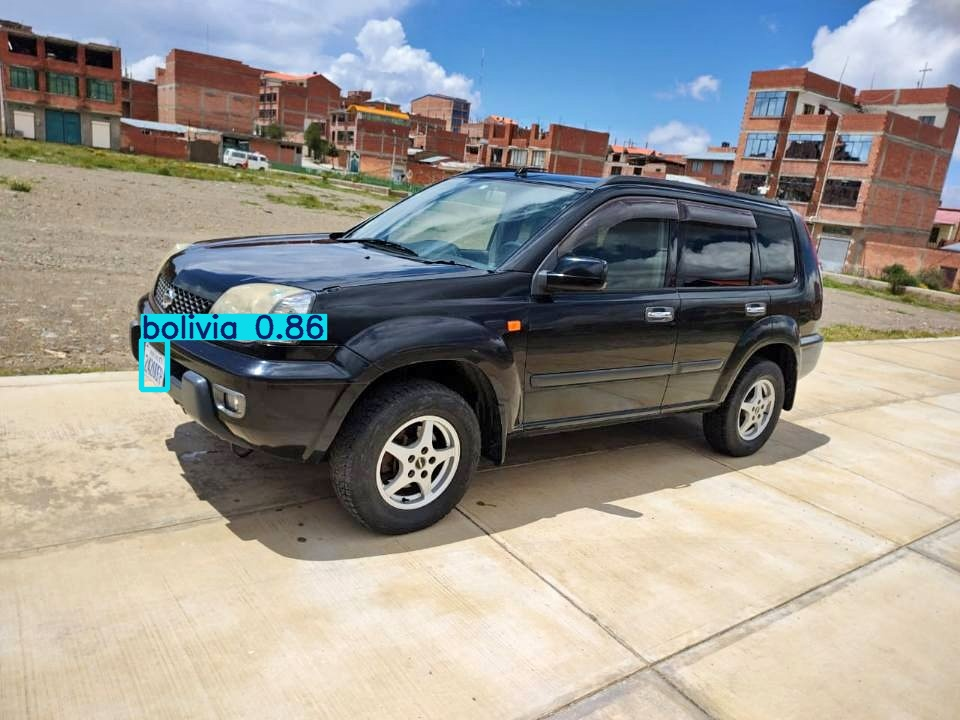

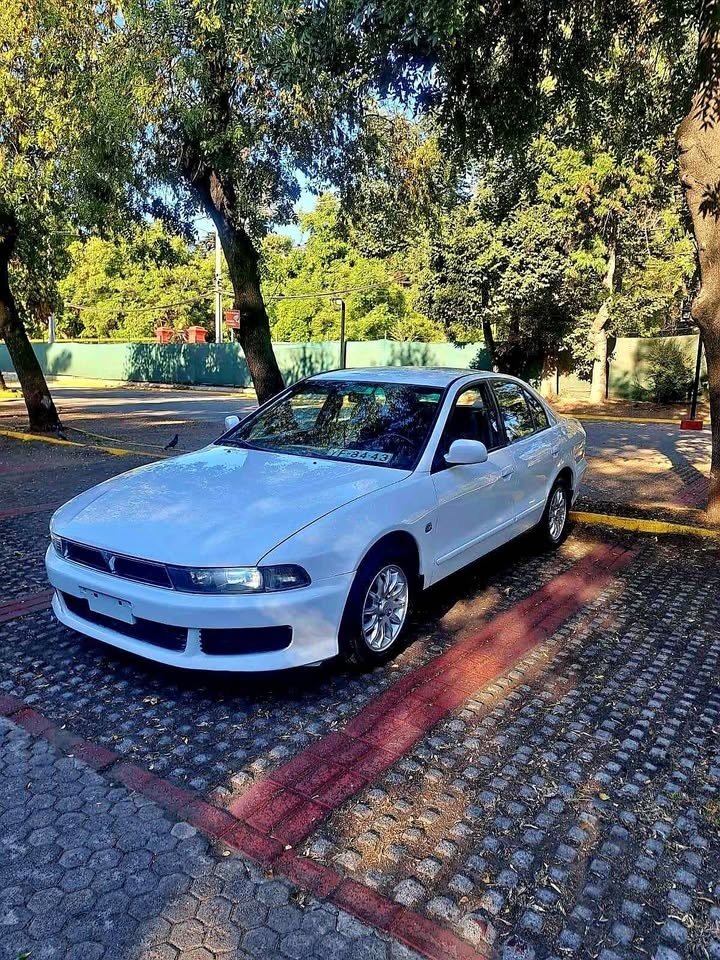

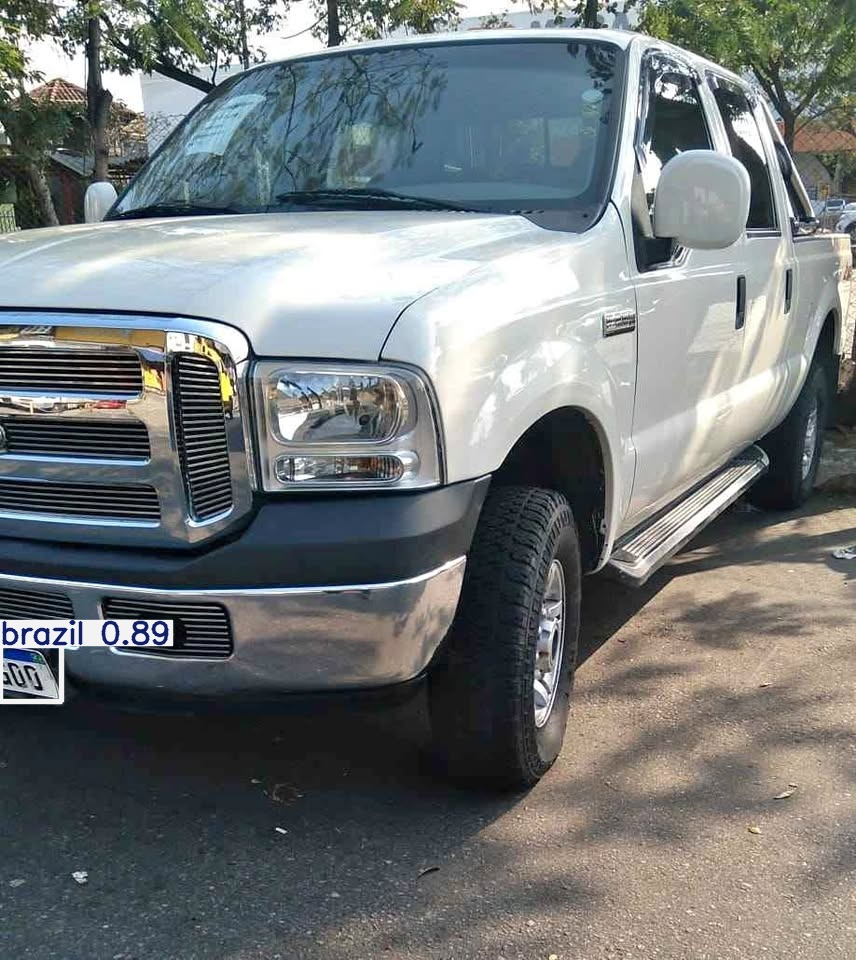

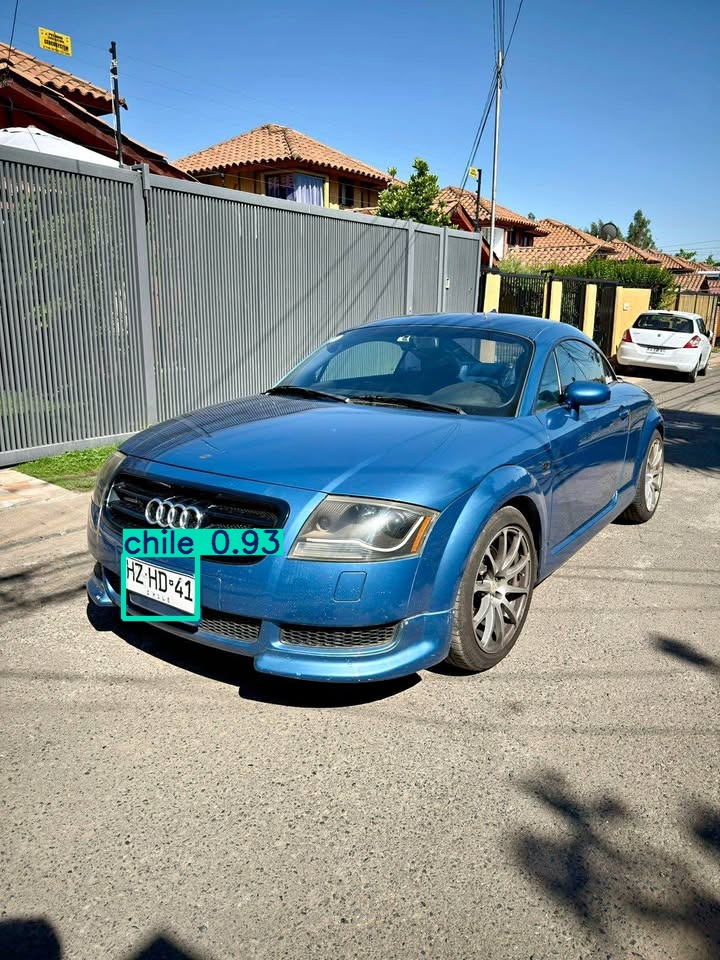

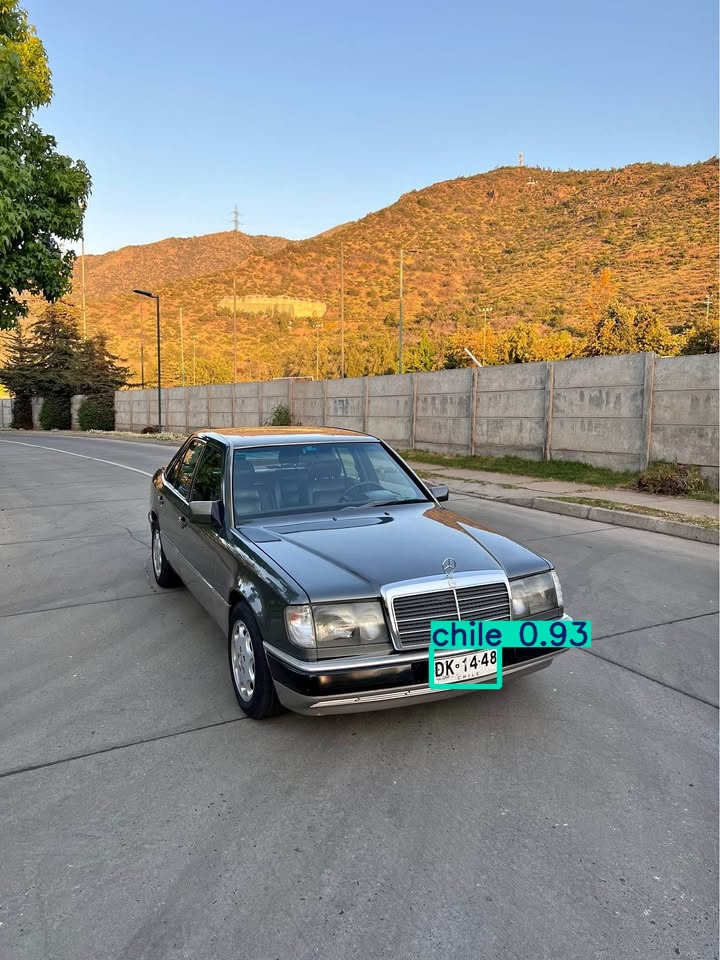

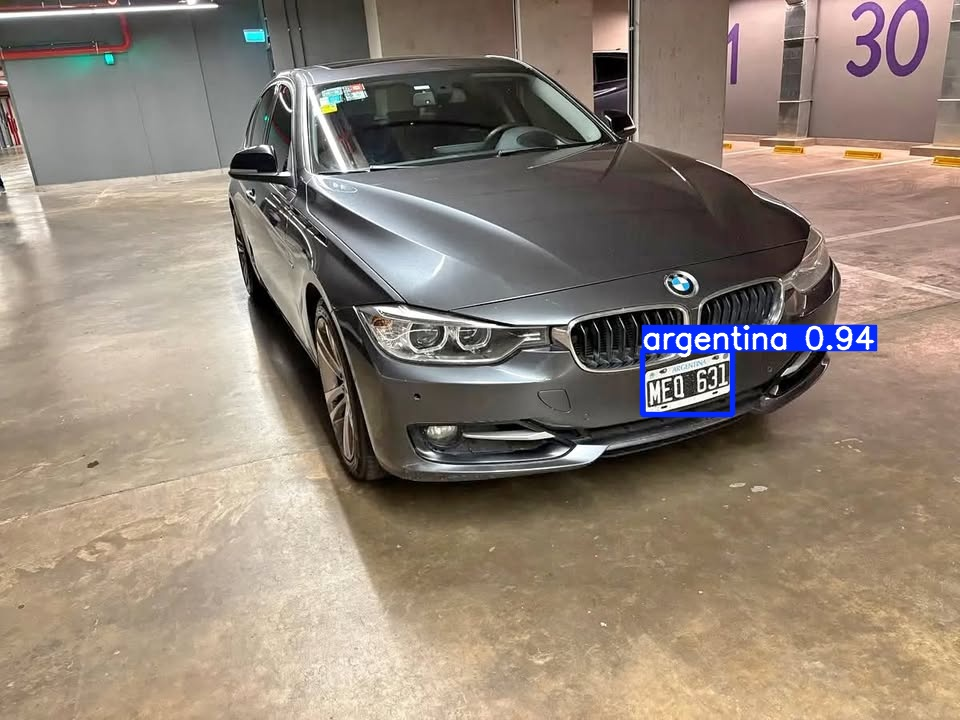

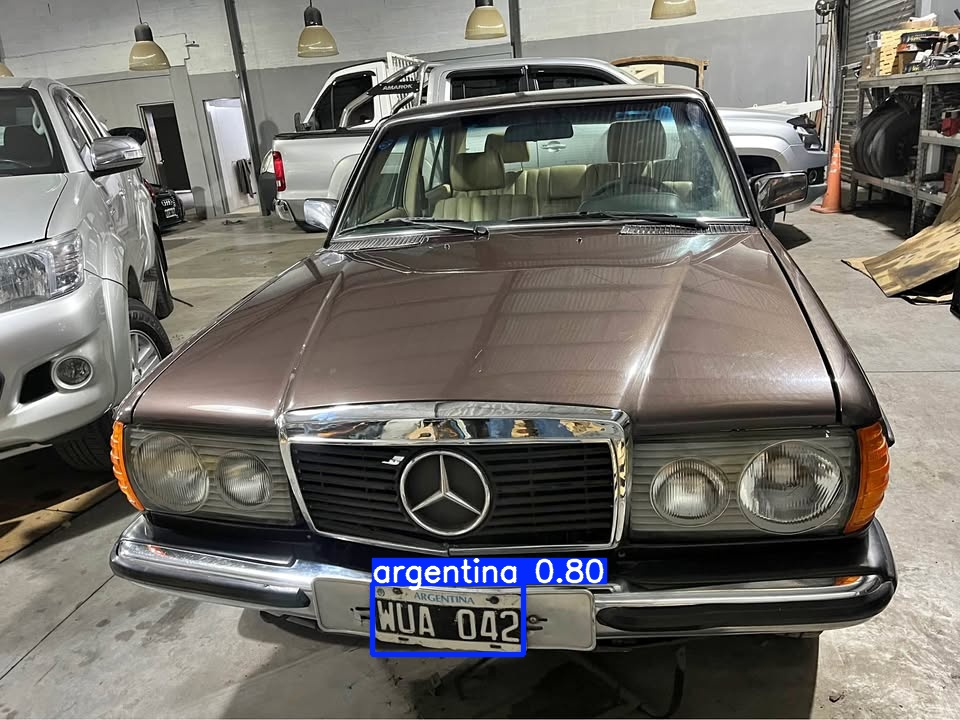

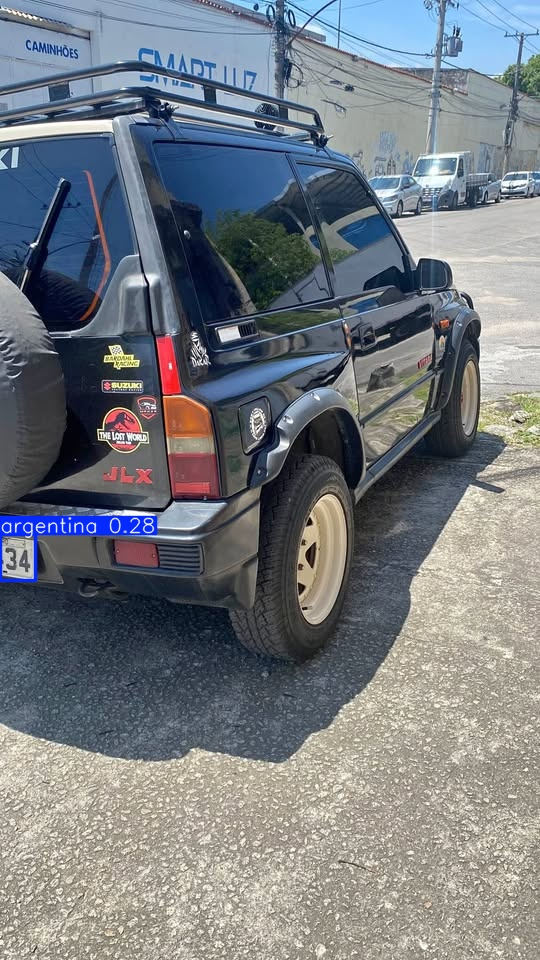

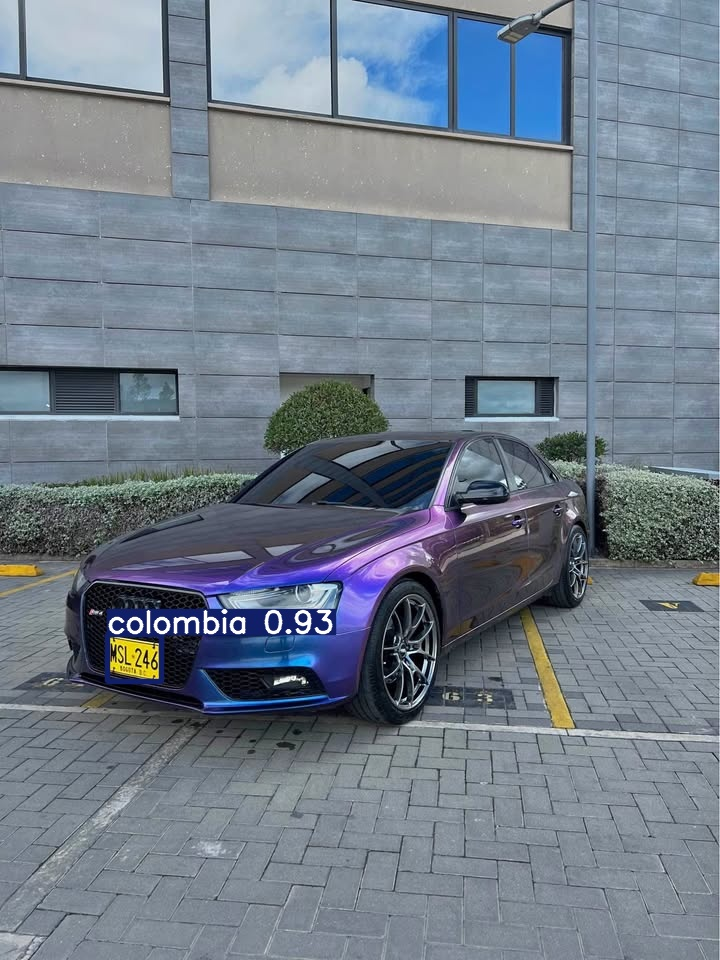

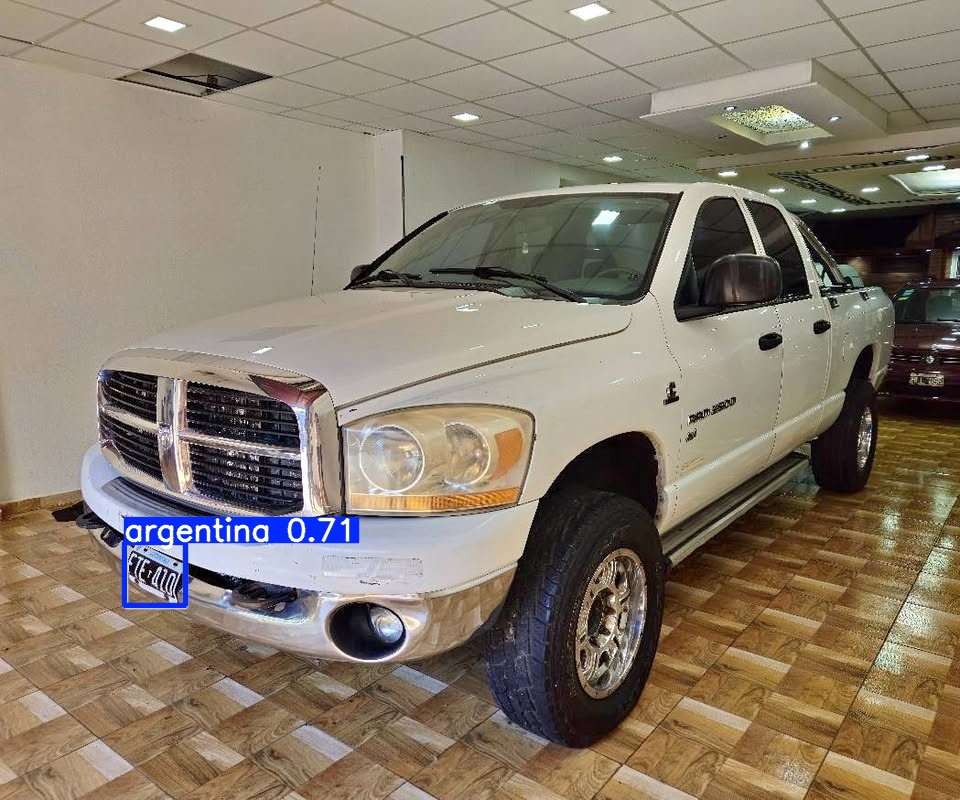

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob("/content/runs/detect/predict/*jpg")[:10]:
    display(Image(filename=image_path, height=400))
    print("\n")